In [ ]:
!pip install transformers
!pip install timm

In [39]:
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from transformers import ViTForImageClassification, ViTImageProcessor
import torch
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from tensorflow.python.keras import backend
import gc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
path = "/content/drive/MyDrive/Bakalaurinis/Final_code"
train_path = os.path.join(path, "my_test_images/images")

IMAGE_SIZE = (512,512)

df = pd.read_csv(os.path.join(path, "my_test_images/test.csv"))

In [5]:
used_models_pytorch = {"vit": os.path.join(path, "models/ViT/checkpoint-5000")}

used_models_keras = {"mobilenet": os.path.join(path, "models/cropnet"),
                     "efficientnetv2s": os.path.join(path, "models/EfficientNetV2/EfficientNetV2S.h5"),
                     "convnext": os.path.join(path, "models/ConvNeXt/ConvNeXtTinyFinal")}

In [6]:
def build_mobilenet3(img_size=(224,224), weights=os.path.join(path, "cropnet")):
    classifier = hub.KerasLayer(weights)
    model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=img_size + (3,)),
    hub.KerasLayer(classifier, trainable=False)])
    return model

In [7]:
def cropnet_preprocess_fn(data):
  image = load_img(os.path.join(train_path, data))
  image = tf.cast(image, tf.float32)
  image = image / 255.
  image = tf.image.resize(image, (224, 224))
  image = tf.expand_dims(image, axis=0)
  return image
  
def distribute_unknown(propabilities):
  return propabilities[:,:-1] + np.expand_dims(propabilities[:,-1]/5, 1)

def cropnet_prediction(model, image_ids):
  predictions = np.empty((0, 5), dtype=np.float32)
  for image_id in tqdm(image_ids, position=0, leave=True):
    image = cropnet_preprocess_fn(image_id)
    pred = distribute_unknown(model(image).numpy())
    predictions = np.vstack((predictions, pred))
  return predictions

In [8]:
df.label = df.label.astype('str')
test_generator = ImageDataGenerator() \
    .flow_from_dataframe(df,
                         directory = train_path,
                         x_col = "image_id",
                         y_col = "label",
                         target_size = IMAGE_SIZE,
                         batch_size = 1,
                         class_mode = "sparse",
                         shuffle = False)

Found 106 validated image filenames belonging to 5 classes.


In [9]:
efficientNetModel = tf.keras.models.load_model(used_models_keras["efficientnetv2s"])
efficientnetPreds = efficientNetModel.predict(test_generator)
backend.clear_session()

try:
    del efficientNetModel
except:
    pass

test_generator.reset()
gc.collect()

106/106 [==============================] - 94s 805ms/step


1226

In [11]:
convnextModel = tf.keras.models.load_model(used_models_keras["convnext"])
convnextPreds = convnextModel.predict(test_generator)
backend.clear_session()

try:
    del convnextModel
except:
    pass

test_generator.reset()
gc.collect()

106/106 [==============================] - 11s 56ms/step


1129

In [12]:
cropnetModel = build_mobilenet3(weights = used_models_keras["mobilenet"])
cropnetPreds = cropnet_prediction(cropnetModel, df['image_id'])

backend.clear_session()

try:
    del cropnetModel
except:
    pass

gc.collect()

100%|██████████| 106/106 [00:05<00:00, 20.77it/s]


275149

In [15]:
vitmodel = ViTForImageClassification.from_pretrained(used_models_pytorch["vit"]).to(device)
image_processor = ViTImageProcessor.from_pretrained(used_models_pytorch["vit"])
def vit_get_predictions(model, img_paths):
  predictions = np.empty((0, 5), dtype=np.float32)
  for img_path in tqdm(img_paths):
    img = Image.open(os.path.join(train_path, img_path))
    pixel_values = image_processor(img, return_tensors="pt")["pixel_values"].to(device)
    model.to(device)
    output = model(pixel_values).logits.softmax(dim=1).detach().cpu().numpy()
    predictions = np.vstack((predictions, output))
  return predictions
vitPreds = vit_get_predictions(vitmodel, df['image_id'])

try:
    del vitmodel
except:
    pass

gc.collect()

100%|██████████| 106/106 [00:05<00:00, 18.64it/s]


72244

In [16]:
sum_predictions = np.sum([vitPreds, efficientnetPreds, convnextPreds, cropnetPreds], axis=0)

In [33]:
y_pred = sum_predictions.argmax(axis=1)
y_true = df.label.astype(int).values

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f'Tikslumas: {accuracy}')
print(f'Preciziskumas: {precision}')
print(f'Atkurimo statistika: {recall}')
print(f'F1 statistika: {f1}')

Tikslumas: 0.9433962264150944
Preciziskumas: 0.9509230769230769
Atkurimo statistika: 0.9268315018315019
F1 statistika: 0.9332835595776772


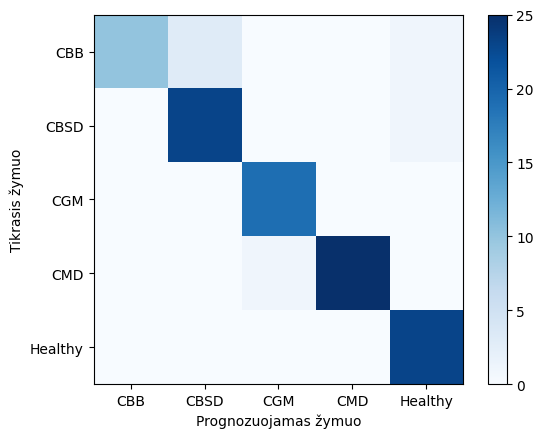

In [43]:
class_names = ['CBB', 'CBSD', 'CGM', 'CMD', 'Healthy']

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# plt.title('Klasifikavimo lentelė')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.xlabel('Prognozuojamas žymuo')
plt.ylabel('Tikrasis žymuo')
plt.show()